In [4]:
import pandas as pd
import os
import pathlib

# Inference

Since in our training we saved model after every epoch, so we have 10 s of models to test and evaluate

first all models one by one on our test dataset and save the results in a csv file for each model.

In [ ]:

import subprocess
import pathlib
import sys

# ---- Config ---------------------------------------------------------------
DATA_ROOT   = "."                               # dataset root
ANN_FILE    = "annotations/testgen_images.txt"       # annotation txt
CKPT_DIR    = pathlib.Path("linear_imaginet_save_origin_calib")
OUT_DIR     = pathlib.Path("batch_results")     # where CSVs land
BATCH_SIZE  = "64"
EPOCH_START, EPOCH_END = 10, 25                 # inclusive range
# ---------------------------------------------------------------------------

OUT_DIR.mkdir(exist_ok=True)

for epoch in range(EPOCH_START, EPOCH_END + 1):
    ckpt = CKPT_DIR / f"model_{epoch}.pt"
    if not ckpt.exists():
        print(f"⚠️  {ckpt} not found – skipping", file=sys.stderr)
        continue

    out_csv = OUT_DIR / f"results_origin_finetuning_{epoch}_sora.csv"
    cmd = [
        "python", "inference.py",
        "--data-root", DATA_ROOT,
        "--ann", ANN_FILE,
        "--ckpt", str(ckpt),
        "--bs", BATCH_SIZE,
        "--out", str(out_csv),
    ]

    print("🚀", " ".join(cmd))
    subprocess.run(cmd, check=True)

print("✅ All done. CSVs are in", OUT_DIR.resolve())


🚀 python inference.py --data-root . --ann annotations/testgen_images.txt --ckpt linear_imaginet_save_origin_calib/model_10.pt --bs 64 --out batch_results/results_origin_finetuning_10_sora.csv
✅ Done — wrote 2000 rows to batch_results/results_origin_finetuning_10_sora.csv
🚀 python inference.py --data-root . --ann annotations/testgen_images.txt --ckpt linear_imaginet_save_origin_calib/model_11.pt --bs 64 --out batch_results/results_origin_finetuning_11_sora.csv
✅ Done — wrote 2000 rows to batch_results/results_origin_finetuning_11_sora.csv
🚀 python inference.py --data-root . --ann annotations/testgen_images.txt --ckpt linear_imaginet_save_origin_calib/model_12.pt --bs 64 --out batch_results/results_origin_finetuning_12_sora.csv
✅ Done — wrote 2000 rows to batch_results/results_origin_finetuning_12_sora.csv
🚀 python inference.py --data-root . --ann annotations/testgen_images.txt --ckpt linear_imaginet_save_origin_calib/model_13.pt --bs 64 --out batch_results/results_origin_finetuning_13_s

### Metrics

Now lets calculate the accuracy of each model's results.

In [10]:
# calculate accuracy and mean/median probabilities for all batch_results folders

for file in os.listdir('batch_results'):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join('batch_results', file))
        # Calculate accuracy and mean/median probabilities, and add intoa a table
        total = len(df)
        num_pred1 = (df['pred_label'] == 1).sum()
        accuracy = num_pred1 / total
        mean_prob_correct = df[df['pred_label'] == 1]['prob_synthetic'].mean()
        median_prob_correct = df[df['pred_label'] == 1]['prob_synthetic'].median()
        print(f"File: {file}, \nAccuracy: {accuracy:.2f}, \nMean Prob Correct: {mean_prob_correct:.2f}, \nMedian Prob Correct: {median_prob_correct:.2f}")
        # Append results to a new DataFrame
        results = pd.DataFrame({
            'file': [file],
            'accuracy': [accuracy],
            'mean_prob_correct': [mean_prob_correct],
            'median_prob_correct': [median_prob_correct]
        })
        
        print("Appending results to summary DataFrame for file:", file)
        results_summary = pd.concat([results_summary, results], ignore_index=True)
# Save the summary results to a CSV file
results_summary.to_csv('results_summary.csv', index=False)



File: results_origin_finetuning_17_sora.csv, 
Accuracy: 0.74, 
Mean Prob Correct: 0.94, 
Median Prob Correct: 1.00
Appending results to summary DataFrame for file: results_origin_finetuning_17_sora.csv
File: results_origin_finetuning_12_sora.csv, 
Accuracy: 0.75, 
Mean Prob Correct: 0.94, 
Median Prob Correct: 1.00
Appending results to summary DataFrame for file: results_origin_finetuning_12_sora.csv
File: results_origin_finetuning_11_sora.csv, 
Accuracy: 0.84, 
Mean Prob Correct: 0.96, 
Median Prob Correct: 1.00
Appending results to summary DataFrame for file: results_origin_finetuning_11_sora.csv
File: results_origin_finetuning_16_sora.csv, 
Accuracy: 0.73, 
Mean Prob Correct: 0.94, 
Median Prob Correct: 1.00
Appending results to summary DataFrame for file: results_origin_finetuning_16_sora.csv
File: results_origin_finetuning_13_sora.csv, 
Accuracy: 0.71, 
Mean Prob Correct: 0.94, 
Median Prob Correct: 1.00
Appending results to summary DataFrame for file: results_origin_finetuning_13

In [11]:
# read results_summary.csv
summary_df = pd.read_csv('results_summary.csv')
# print the summary DataFrame
print(summary_df.head(5))

                                    file  accuracy  mean_prob_correct  \
0  results_origin_finetuning_10_sora.csv    0.7310           0.941485   
1  results_origin_finetuning_17_sora.csv    0.7390           0.941207   
2  results_origin_finetuning_12_sora.csv    0.7520           0.944445   
3  results_origin_finetuning_11_sora.csv    0.8415           0.959525   
4  results_origin_finetuning_16_sora.csv    0.7285           0.940011   

   median_prob_correct  
0              0.99605  
1              0.99780  
2              0.99660  
3              0.99910  
4              0.99610  


In [15]:
# add a column to the summary DataFrame with the epoch number extracted from the file name
summary_df['epoch'] = summary_df['file'].str.extract(r'_(\d+)_sora\.csv').astype(int)
# sort the summary DataFrame by epoch
summary_df = summary_df.sort_values(by='epoch')
# save the summary DataFrame to a new CSV file
summary_df.to_csv('results_summary_sorted.csv', index=False)
# print the sorted summary DataFrame
print(summary_df.head(5))

                                     file  accuracy  mean_prob_correct  \
0   results_origin_finetuning_10_sora.csv    0.7310           0.941485   
16  results_origin_finetuning_10_sora.csv    0.7310           0.941485   
3   results_origin_finetuning_11_sora.csv    0.8415           0.959525   
2   results_origin_finetuning_12_sora.csv    0.7520           0.944445   
5   results_origin_finetuning_13_sora.csv    0.7120           0.937660   

    median_prob_correct  epoch  
0               0.99605     10  
16              0.99605     10  
3               0.99910     11  
2               0.99660     12  
5               0.99590     13  


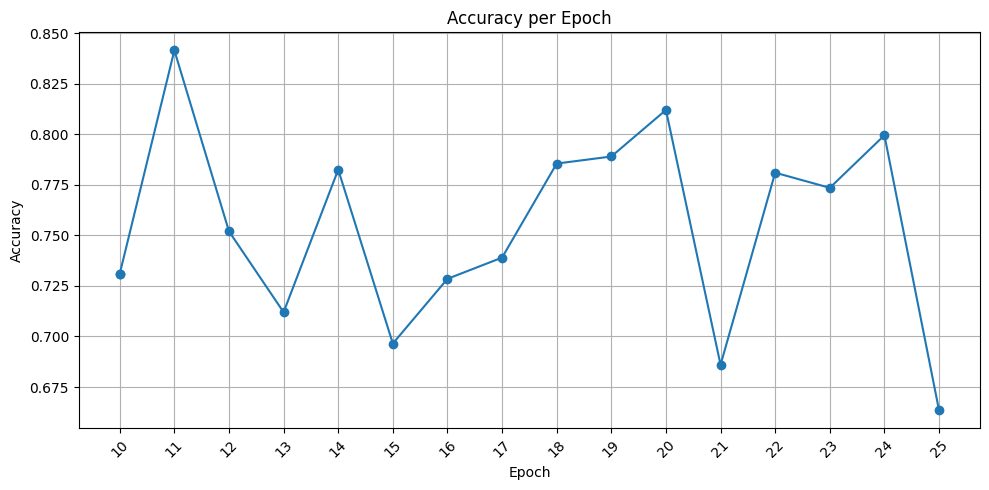

In [17]:
# Graph the accuracy on y axis and epoch on x axis
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(summary_df['epoch'], summary_df['accuracy'], marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# Set x-axis ticks to show all integer values
plt.xticks(range(summary_df['epoch'].min(), summary_df['epoch'].max() + 1))
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig('accuracy_per_epoch.png')
# Show the plot
plt.show()


Miscellaneous snippets

In [1]:
print(f"Total images: {total}")
print(f"Number of images predicted as synthetic (pred_label=1): {num_pred1}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Mean probability for pred_label=1: {mean_prob_correct:.4f}")
print(f"Median probability for pred_label=1: {median_prob_correct:.4f}")

NameError: name 'total' is not defined